In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier, XGBRFClassifier

#### Import data

In [2]:
housevotes_df = pd.read_csv('../../data/02_intermediate/HouseVotesFeatures_12_18_0814PM.csv')

In [3]:
housevotes_df.shape

(1740, 57)

In [4]:
housevotes_df.shape

(1740, 57)

#### Code dummy for `swing_district`

Defined as `dem_L10_voteshare` between 0.4 and 0.6

`target`: A Democratic win

In [5]:
housevotes_df['swing_district'] = ((housevotes_df.dem_L5_voteshare > 0.4) & (housevotes_df.dem_L5_voteshare < 0.6)).astype(int)
housevotes_df.swing_district.value_counts()

0    1227
1     513
Name: swing_district, dtype: int64

### Assign IDs to each district

In [6]:
district_id_mapping = dict(zip(housevotes_df.district_id.unique(), np.arange(1, 436)))

In [8]:
housevotes_df['idx'] = housevotes_df.district_id.map(district_id_mapping)

Old tests to try on our custom TTS function

In [10]:
# set(train_s1.idx.unique()) == set(train_s2.idx.unique())

In [11]:
# test_set = set(list(set(train.idx.unique())) + [1000, 2000])

In [12]:
# set(train.idx.unique()) - set(train_s1.idx.unique()) - set(train_s2.idx.unique())  # looks good

In [13]:
# test_set - set(train_s1.idx.unique()) - set(train_s2.idx.unique())  # looks good

### Define a custom train-test-split function

In [14]:
def district_train_test_split(dataframe, idx_colname, np_seed, tts_seed, test_size):
    """
    Split a dataframe containing numeric IDs for each congressional district
    into train and test sets, such that there is no leakage of districts between
    the train and test sets.
    
    Parameters
    ----------
    
        dataframe : a dataframe with a column for district-level numeric ID
        idx_colname : the name of the column containing the district numberic ID (string)
        np_seed : the random seed for Numpy, for splitting the districts into 2 samples
        tts_seed : the random state seed to be passed into train_test_split()
        test_size : the test size to be passed into train_test_split()
        
    Returns
    -------
        X_train, X_test, y_train, y_test (also prints a report on their shapes)
        
    """
    np.random.seed(np_seed)
    population = np.arange(1, 436)
    sample_1_ids = np.random.choice(population, 200, replace=False)
    sample_2_ids = list(set(population) - set(sample_1_ids))
    sample_1 = dataframe[dataframe[idx_colname].isin(sample_1_ids)]
    sample_2 = dataframe[dataframe[idx_colname].isin(sample_2_ids)]
    train_s1, test_s1 = train_test_split(sample_1, 
                                         test_size=test_size, 
                                         random_state=tts_seed, 
                                         stratify=sample_1[['target', 'swing_district']]
                                        )
    train_s2, test_s2 = train_test_split(sample_2,
                                         test_size=test_size,
                                         random_state=tts_seed, 
                                         stratify=sample_2[['target', 'swing_district']]
                                        )
    train = pd.concat([train_s1, train_s2], axis=0)
    test = pd.concat([test_s1, test_s2], axis=0)
    X_train = train.drop(['target', 'idx', 'swing_district'], axis=True)
    y_train = train['target']
    X_test = test.drop(['target', 'idx', 'swing_district'], axis=True)
    y_test = test['target']

    print('Shape for X_train:', X_train.shape)
    print('Shape for y_train:', y_train.shape)
    print('Shape for X_test:', X_test.shape)
    print('Shape for y_test:', y_test.shape)
    
    return X_train, X_test, y_train, y_test

## Model 1

Regressors: Just House vote histories

In [15]:
m1 = [
#  'yr_district_id',
#  'winner_votes',
#  'totalvotes',
#  'year',
#  'state',
#  'winner',
#  'winner_party',
#  'writein',
#  'district_id',
#  'winner_voteshare',
#  'total_dem_votes',
#  'total_rep_votes',
#  'total_dem_vote_share',
#  'total_rep_vote_share',
#  'L1_winner',
#  'L2_winner',
#  'L3_winner',
#  'L4_winner',
#  'L5_winner',
#  'L6_winner',
#  'L7_winner',
#  'L8_winner',
#  'L9_winner',
#  'L10_winner',
#  'incumbent_party',
 'dL1_winner',
 'dL2_winner',
 'dL3_winner',
 'dL4_winner',
 'dL5_winner',
 'dL6_winner',
 'dL7_winner',
 'dL8_winner',
 'dL9_winner',
 'dL10_winner',
 'incumbent_L5_races',
 'incumbent_L4_races',
 'incumbent_L3_races',
 'incumbent_L2_races',
 'incumbent_L10_races',
#  'rep_wins',
#  'dem_wins',
 'rep_L5_wins',
 'rep_L4_wins',
 'rep_L3_wins',
 'rep_L2_wins',
 'rep_L1_wins',
 'rep_L10_wins',
 'dem_L10_wins',
 'dem_L5_wins',
 'dem_L4_wins',
 'dem_L3_wins',
 'dem_L2_wins',
 'dem_L1_wins',
 'rep_L10_voteshare',
 'rep_L5_voteshare',
 'rep_L4_voteshare',
 'rep_L3_voteshare',
 'rep_L2_voteshare',
 'rep_L1_voteshare',
 'dem_L10_voteshare',
 'dem_L5_voteshare',
 'dem_L4_voteshare',
 'dem_L3_voteshare',
 'dem_L2_voteshare',
 'dem_L1_voteshare',
 'target',
#  'top_dem_votes',
#  'top_dem_candidate',
#  'top_rep_votes',
#  'top_rep_candidate',
 'dem_incumbent_in_race',
 'rep_incumbent_in_race',
 'swing_district',
 'idx'
]

In [25]:
features_model_1 = [
 'dL1_winner',
 'dL2_winner',
 'dL3_winner',
 'dL4_winner',
 'dL5_winner',
#  'dL6_winner',
#  'dL7_winner',
#  'dL8_winner',
#  'dL9_winner',
#  'dL10_winner',
 'incumbent_L5_races',
 'incumbent_L4_races',
 'incumbent_L3_races',
 'incumbent_L2_races',
#  'incumbent_L10_races',
 'rep_L5_wins',
#  'rep_L10_wins',
#  'dem_L10_wins',
 'dem_L5_wins',
 'rep_L4_wins',
 'rep_L3_wins',
 'rep_L2_wins',
 'rep_L1_wins',
 'dem_L4_wins',
 'dem_L3_wins',
 'dem_L2_wins',
 'dem_L1_wins',
 'rep_L5_voteshare',
#  'rep_L10_voteshare',
 'rep_L4_voteshare',
 'rep_L3_voteshare',
 'rep_L2_voteshare',
 'rep_L1_voteshare',
#  'dem_L10_voteshare',
 'dem_L5_voteshare',
 'dem_L4_voteshare',
 'dem_L3_voteshare',
 'dem_L2_voteshare',
 'dem_L1_voteshare',
 'target',
 'dem_incumbent_in_race',
 'rep_incumbent_in_race',
 'swing_district',
 'idx'
]

In [26]:
len(m1)

44

In [27]:
len(features_model_1)

34

#### Train test split with `features_model_1`

In [81]:
X_train, X_test, y_train, y_test = district_train_test_split(dataframe=housevotes_df[features_model_1], 
                                                             idx_colname='idx',
                                                             np_seed=123, 
                                                             tts_seed=123, 
                                                             test_size=0.2
                                                             )

Shape for X_train: (1392, 31)
Shape for y_train: (1392,)
Shape for X_test: (348, 31)
Shape for y_test: (348,)


Heatmap to visualize correlations

In [74]:
# housevotes_df[features_model_1].corr()[['target']]

In [75]:
# plt.figure(figsize = (20,16))
# sns.heatmap(housevotes_df[features_model_1].corr(), center=0, annot = True)

## Random Forest

**Test #1:** use 2012, 2014 2016 as training set, and 2018 as the testing set

Along with all features in `features_model_1`

NOT using our custom train-test-split

In [76]:
# train = housevotes_df[housevotes_df.year.isin([2012, 2014, 2016])]
# train.shape

(1305, 59)

In [77]:
# test = housevotes_df[housevotes_df.year.isin([2018])]
# test.shape

(435, 59)

In [78]:
# X_train = train[features_model_1].drop(['target', 'idx', 'swing_district'], axis=1)
# y_train = train['target']
# print(X_train.shape)
# print(y_train.shape)

(1305, 31)
(1305,)


In [79]:
# X_test = test[features_model_1].drop(['target', 'idx', 'swing_district'], axis=1)
# y_test = test['target']
# print(X_test.shape)
# print(y_test.shape)

(435, 31)
(435,)


**Null accuracy**: "accuracy that could be achieved by always predicting the most frequent class"

In [61]:
# max(y_test.mean(), 1 - y_test.mean())

#### Test #2 Baseline model

Use `dem_L1_wins` as the sole predictor

Still splitting train/test on 2012/14/16 and 2018

In [62]:
# X_test.dem_L1_wins.mean()

In [63]:
# housevotes_df.dem_L1_wins.mean()

In [64]:
# y_test.value_counts()

In [82]:
rf = RandomForestClassifier(random_state=23, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_class = rf.predict(X_test)
y_pred_prob = rf.predict_proba(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))

Test Accuracy score:  0.9425287356321839
Test F1 score:  0.940119760479042


In [83]:
y_pred_prob

array([[0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.66, 0.34],
       [0.97, 0.03],
       [0.  , 1.  ],
       [0.84, 0.16],
       [0.21, 0.79],
       [0.53, 0.47],
       [0.  , 1.  ],
       [0.72, 0.28],
       [1.  , 0.  ],
       [0.93, 0.07],
       [0.  , 1.  ],
       [0.08, 0.92],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.48, 0.52],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.99, 0.01],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.74, 0.26],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  ,

In [84]:
metrics.confusion_matrix(y_test, y_pred_class)

array([[171,  13],
       [  7, 157]], dtype=int64)

#### Look at feature importance

In [85]:
feat_importance = pd.DataFrame((zip(X_train.columns, rf.feature_importances_)))
feat_importance.columns = ['feature_name', 'importance']
feat_importance.importance = feat_importance.importance.apply(lambda x: '%.3f' % x) 
feat_importance.sort_values('importance', ascending=False)

,feature_name,importance
23,rep_L1_voteshare,0.156
28,dem_L1_voteshare,0.111
18,dem_L1_wins,0.109
14,rep_L1_wins,0.072
22,rep_L2_voteshare,0.066
17,dem_L2_wins,0.065
30,rep_incumbent_in_race,0.042
27,dem_L2_voteshare,0.038
21,rep_L3_voteshare,0.038
13,rep_L2_wins,0.038


## Logistic regression

In [89]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
y_pred_class = logreg.predict(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

Test Accuracy score:  0.9310344827586207
Test F1 score:  0.9263803680981596


c:\users\joey\learn-env2\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[173,  11],
       [ 13, 151]], dtype=int64)

## KNN

In [98]:
scores = []
for k in range(1, 36):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_class = knn.predict(X_test)
#     print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
#     print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
    scores.append(metrics.accuracy_score(y_test, y_pred_class))

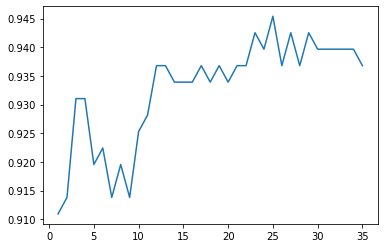

In [99]:
plt.plot(range(1, 36), scores)  # set k=25

In [100]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print('Test Accuracy score: ', metrics.accuracy_score(y_test, y_pred_class))
print('Test F1 score: ', metrics.f1_score(y_test, y_pred_class))
metrics.confusion_matrix(y_test, y_pred_class)

Test Accuracy score:  0.9454022988505747
Test F1 score:  0.9422492401215805


array([[174,  10],
       [  9, 155]], dtype=int64)

## AdaBoost

In [103]:
ada_class = AdaBoostClassifier(random_state = 12)
ada_class.fit(X_train, y_train)
print(ada_class.score(X_train, y_train))
print(ada_class.score(X_test, y_test))

0.9209770114942529
0.9195402298850575


## XGBoost

In [105]:
xgb_class = XGBClassifier(random_state = 12)
xgb_rf_class = XGBRFClassifier(random_state = 12)
xgb_class.fit(X_train, y_train)
print(xgb_class.score(X_train, y_train))
print(xgb_class.score(X_test, y_test))

xgb_rf_class.fit(X_train, y_train)
print(xgb_rf_class.score(X_train, y_train))
print(xgb_rf_class.score(X_test, y_test))

0.9626436781609196
0.9482758620689655
0.9461206896551724
0.9511494252873564


## Testing (Omer's ideas)

In [ ]:
(housevotes_df.dem_L2_wins - housevotes_df.dem_L1_wins).

In [ ]:
test_flips_df = housevotes_df[(housevotes_df.target - housevotes_df.dem_L1_wins) != 0]  # flips in either direction
test_flips_df.shape

In [ ]:
(housevotes_df.target - housevotes_df.dem_L1_wins).value_counts()

In [ ]:
test_flips_df.groupby(['dem_L1_wins', 'dem_L2_wins']).size()

In [ ]:
housevotes_df.dem_L2_wins.value_counts()

In [ ]:
test_df = pd.concat([X_test.reset_index(drop=True), pd.Series(y_pred_prob[:, 1]), y_test.reset_index(drop=True)], axis=1)
test_df = test_df.rename(columns={0:'predicted_proba'})
test_df.loc[(test_df.swing_district == 1) & (test_df.incumbent_in_race == 0), ['dL1_winner', 
                                                                               'dL1_winner', 
                                                                               'incumbent_L3_races', 
                                                                               'incumbent_in_race', 
#                                                                                'swing_district', 
                                                                               'predicted_proba', 
                                                                               'target']]#.shape

## To do:

- Try MERF, logistic, knn
- baseline model: always predict what it was before (using just 1 lag term)
- check all columns are supposed to be there
- dig into exact observations where it changed to 1 in 2018, what is driving the prediction there
- build a model with swing states (the 60) matched on 60 non-swings, try with other estimators too (logistic, SVM, etc.)

Later:
- grid search for hyperparameter tuning
- k-folds cross validataion